# Main body of code to view M25 data

### uses the following data:

* Preprocesed accident, Vehicles and Casualty datasets
* Speed camera data for M25 
* Shape fils of M25 roads and UK postcode map

### Process flow

1. import packages
2. Load and merge (M25) datasets
3. -- check for stats on data
4. filter data
5. -- check for stats on filtered data
6. Set up plot area 'scenarios'
7. choose scenario
8. Plot

In [1]:
'''
Initialisation
* Import packages
* Initialise data
'''

#plot
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
%matplotlib inline

#Pandas
import pandas as pd
import geopandas as gpd

#utilities
import numpy as np
import time, os

#path definitions
print(os.getcwd())

C:\GA\RTA


In [2]:
'''
Load datasets & generate DataFrames
Currently configured for M25 Motorway
'''
print(os.getcwd())

cameras_csv_file = "Data/Speed_cameras.csv"
accidents_csv_file = "Data/Accidents.csv"
vehicles_csv_file = "Data/Vehicles.csv"
casualties_csv_file = "Data/Casualties.csv"

# Generate M25 Camera DataFrame
df_cam = pd.read_csv(cameras_csv_file)
df_cam['position'] = zip(df_cam['latitude'], df_cam['longitude'])
M25_cam = df_cam[(df_cam['import'] == "Y") & (df_cam['road'] == "M25 ")]

# generate Accidents dataFrame
df_acc = pd.read_csv(accidents_csv_file)
df_acc['position'] = zip(df_acc['latitude'], df_acc['longitude'])

# Generate RTA 'Merged' DataFrame
df_cas = pd.read_csv(casualties_csv_file)
df_veh = pd.read_csv(vehicles_csv_file)
df_RTA = df_veh.merge(df_cas, on=['accident_index','vehicle_reference'], how = 'outer')
df_RTA = df_acc.merge(df_RTA, on=['accident_index'], how = 'outer')

C:\GA\RTA


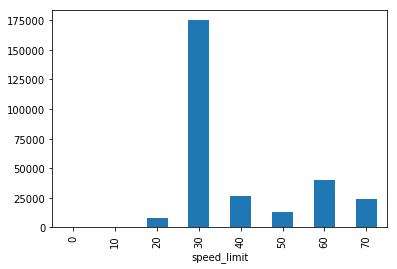

In [3]:
'''
Bar chart of checking (pre_filtered) data
'''

col = 'speed_limit'
df_RTA.groupby([col])[col].count().plot(kind='bar')
plt.show()

In [4]:
'''
M25 Accident filtered Scenarios (currently manually changed)
'''

def M25_scenarios(df):
    return df[(
        (df.first_road_class <= 2) & 
        (df.accident_severity <= 100) & 
        (df.speed_limit < 100) &
        (df.sex_of_driver < 3)
    )]

df_RTA_M25 = M25_scenarios(df_RTA)

print(df_RTA_M25.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14174 entries, 12345 to 285508
Data columns (total 42 columns):
accident_index                                 14174 non-null object
location_easting_osgr                          14171 non-null float64
location_northing_osgr                         14171 non-null float64
longitude                                      14171 non-null float64
latitude                                       14171 non-null float64
police_force                                   14174 non-null int64
accident_severity                              14174 non-null int64
number_of_vehicles                             14174 non-null int64
number_of_casualties                           14174 non-null int64
date                                           14174 non-null object
day_of_week                                    14174 non-null int64
time                                           14174 non-null object
local_authority_(district)                     14174 non-nu

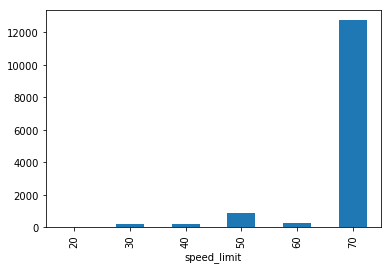

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,...,sex_of_driver,age_of_driver,engine_capacity_(cc),propulsion_code,age_of_vehicle,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty
12345,201501ID60010,507530.0,177060.0,-0.452856,51.482283,1,3,3,3,02/02/2015,...,1,40,6871,2,1,NaN,NaN,NaN,NaN,NaN
12346,201501ID60010,507530.0,177060.0,-0.452856,51.482283,1,3,3,3,02/02/2015,...,1,40,998,1,7,1.0,1.0,1.0,40.0,7.0
12347,201501ID60010,507530.0,177060.0,-0.452856,51.482283,1,3,3,3,02/02/2015,...,1,40,998,1,7,2.0,2.0,2.0,62.0,9.0
12348,201501ID60010,507530.0,177060.0,-0.452856,51.482283,1,3,3,3,02/02/2015,...,1,40,998,1,7,3.0,2.0,1.0,35.0,6.0
12349,201501ID60010,507530.0,177060.0,-0.452856,51.482283,1,3,3,3,02/02/2015,...,1,52,1798,8,1,NaN,NaN,NaN,NaN,NaN


In [5]:
'''
Bar chart of checking (pre-plot) data
'''
col = 'speed_limit'
df_RTA_M25.groupby([col])[col].count().plot(kind='bar')
plt.show()
df_RTA_M25.head()

In [6]:
'''
Map plot parameters by scenario
temporary manual input point for scenario configuration

resolution c, l, i, h, f or None. c:'course' f:'full' impacts plot time (20-120 seconds on my machine)

'''

p_parm_cols = ['scenario', 'resolution', 'projection', 
               'lat_0', 'lon_0', 
               'llcrnrlon', 'llcrnrlat', 'urcrnrlon', 'urcrnrlat',
               'approx_exec_time(s)']
p_parms = pd.DataFrame([
    ['Full_UK_Map', 'f', 'merc', 54.5, -4.36, -10.7, 49.87, 2.06, 58.76, 300],
    ['M25_M4_junction', 'c', 'merc', 51.494765, -0.494250, -0.504764, 51.487391, -0.480290, 51.500801, 150],
    ['M25', 'c', 'merc', 51.5, -4.36, -0.65, 51.2, 0.35, 51.8, 150],
    ['M25_North_segment', 'c', 'merc', 51.494765, -0.494250, -0.55, 51.487, -0.40, 51.5, 160],
    ['Wide_M25_North_segment', 'c', 'merc', 54.5, -4.36, -0.6, 51.487, -0.3, 51.5, 200]
], columns=p_parm_cols)

p_parms = p_parms.set_index(['scenario'])
p_parms.head()

,resolution,projection,lat_0,lon_0,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,approx_exec_time(s)
scenario,,,,,,,,,
Full_UK_Map,f,merc,54.500000,-4.36000,-10.700000,49.870000,2.06000,58.760000,300
M25_M4_junction,c,merc,51.494765,-0.49425,-0.504764,51.487391,-0.48029,51.500801,150
M25,c,merc,51.500000,-4.36000,-0.650000,51.200000,0.35000,51.800000,150
M25_North_segment,c,merc,51.494765,-0.49425,-0.550000,51.487000,-0.40000,51.500000,160
Wide_M25_North_segment,c,merc,54.500000,-4.36000,-0.600000,51.487000,-0.30000,51.500000,200


In [7]:
#temporary manual input point for scenario choice
s = p_parms.ix['Full_UK_Map'] #see approximate execution timings in p_parms dataframe - can be time consuming!
print s

resolution                 f
projection              merc
lat_0                   54.5
lon_0                  -4.36
llcrnrlon              -10.7
llcrnrlat              49.87
urcrnrlon               2.06
urcrnrlat              58.76
approx_exec_time(s)      300
Name: Full_UK_Map, dtype: object


C:\Users\Iain\Anaconda3\envs\GA\lib\site-packages\mpl_toolkits\basemap\__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


Map Draw: 72.8109998703 seconds 


C:\Users\Iain\Anaconda3\envs\GA\lib\site-packages\mpl_toolkits\basemap\__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\Iain\Anaconda3\envs\GA\lib\site-packages\mpl_toolkits\basemap\__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Cameras markers: 0.952000141144 seconds 
Accidents markers: 144.642999887 seconds 
Total Plot time: 218.406999826 seconds 


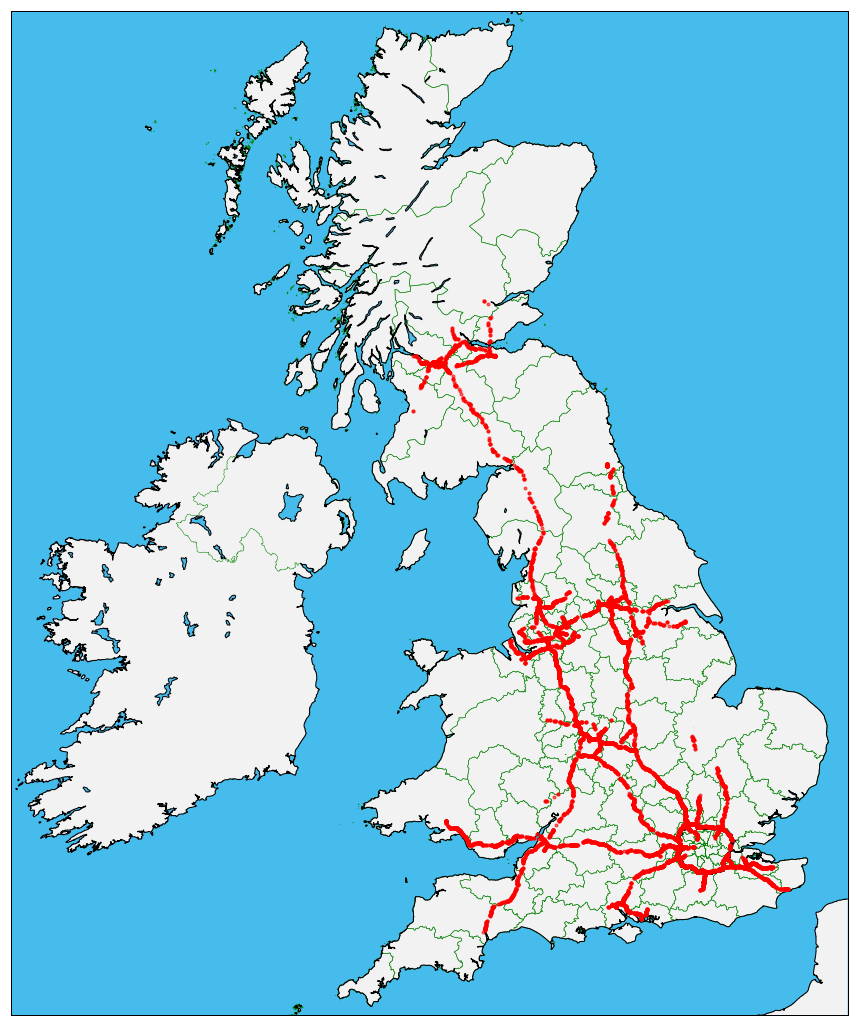

In [8]:
'''
Plot required map (currently under assessment!)

#NOTE! - runtime high if all accidents plotted
       - better to limit though earlier filter (see 'Load datasets & generate DataFrame)

'''
def plot_accidents(pos):
    global count
    x, y = m(pos[1], pos[0])
    m.plot(x, y, 'o', markersize=3, color='red', alpha=0.6)

def plot_cameras(pos):
    global count
    x, y = m(pos[1], pos[0])
    m.plot(x, y, 'x', markersize=3, color='k', alpha=0.8)

start_time_MD = time.time()

#Initilise map segment parameters
postcode_shape_file = 'Data/Areas'
M25_shape_file = 'Data/M25'

# create map segment and resolution
fig, ax = plt.subplots(figsize=(15,25))
m = Basemap(resolution=s[0], #c, l, i, h, f or None
            projection=s[1], #always 'merc'
            lat_0 = s[2], lon_0 = s[3], #centre coords
            llcrnrlon = s[4], llcrnrlat = s[5], #lower left coords
            urcrnrlon = s[6], urcrnrlat = s[7]) #uper right coords

# Draw map
m.readshapefile(postcode_shape_file, 'areas', color = 'green')
m.readshapefile(M25_shape_file, 'M25', color ='brown')
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()

print "Map Draw: %s seconds " % (time.time() - start_time_MD)

'''
superimpose M25 roads cameras, accidents
'''

start_time_CM = time.time()    

# plot all M25 cameras on map
M25_cam.position.apply(plot_cameras)
print "Cameras markers: %s seconds " % (time.time() - start_time_CM)

start_time_AM = time.time()   

# plot all M25 accidents on map
df_RTA_M25.position.apply(plot_accidents)
print "Accidents markers: %s seconds " % (time.time() - start_time_AM)
 
m
print "Total Plot time: %s seconds " % (time.time() - start_time_MD)